# Set up

In [6]:
from wsi import filter
from wsi import slide
from wsi import util

FILE = 'data/U.svs'

In [7]:
%matplotlib inline

# Otsu pipeline

Source: [A generalized deep learning framework for whole-slide image segmentation and analysis](https://www.nature.com/articles/s41598-021-90444-8)

RGB                  | Time: 0:00:00.000328  Type: uint8   Shape: (408, 466, 3)


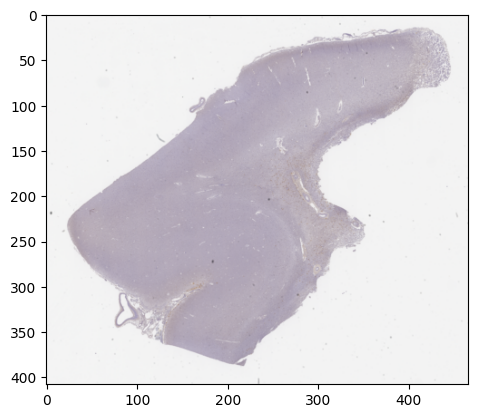

In [19]:
t = util.Time()
FILE = 'data/U.svs'
np_img = slide.slide_to_scaled_np_image(FILE, 64)
util.display_img(np_img)

Gray                 | Time: 0:00:00.005921  Type: uint8   Shape: (408, 466)
Complement           | Time: 0:00:00.000229  Type: uint8   Shape: (408, 466)


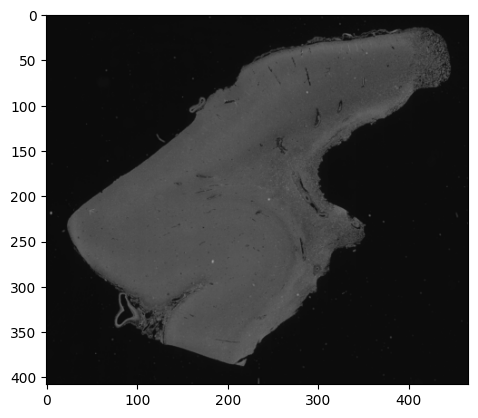

In [20]:
grayscale = filter.filter_rgb_to_grayscale(np_img)
complement = filter.filter_complement(grayscale)
util.display_img(complement)

Median filtering on RGB image

Median               | Time: 0:00:00.158580  Type: uint8   Shape: (408, 466, 3)


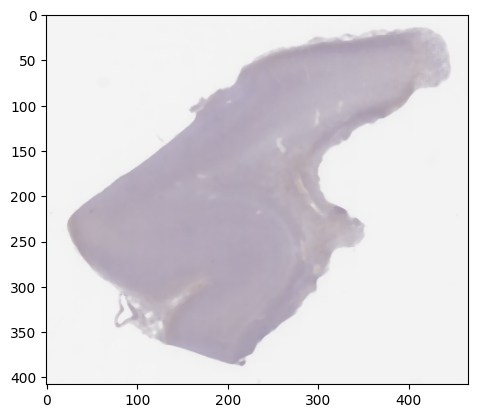

In [21]:
md = filter.filter_median(np_img, size=5)
util.display_img(md)

RGB to HSV           | Time: 0:00:00.035564  Type: float64 Shape: (408, 466, 3)


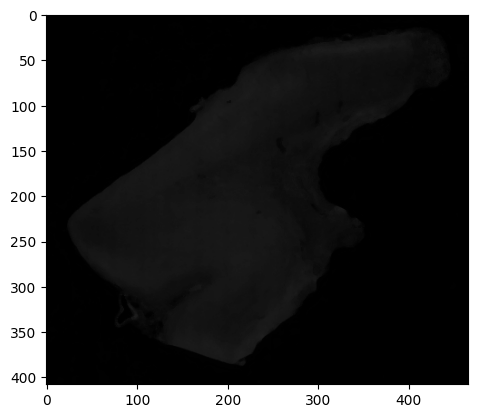

In [22]:
saturation = filter.filter_rgb_to_hsv(md)[:, :, 1]
util.display_img(saturation)

Otsu Threshold       | Time: 0:00:00.004372  Type: uint8   Shape: (408, 466)


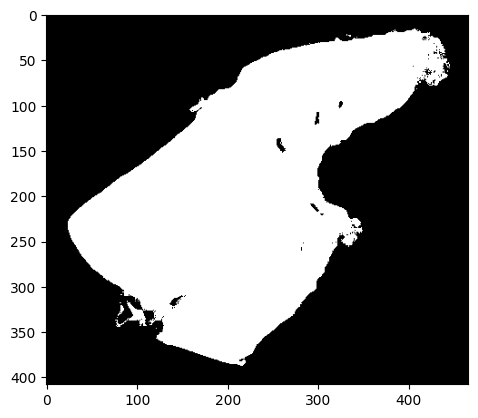

In [23]:
otsu = filter.filter_otsu_threshold(saturation)
util.display_img(otsu)

Binary Dilation      | Time: 0:00:00.012465  Type: uint8   Shape: (408, 466)


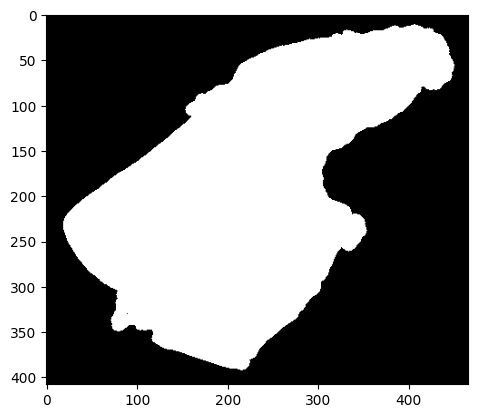

In [24]:
dilation = filter.filter_binary_dilation(otsu, disk_size=5)
util.display_img(dilation)

Mask RGB             | Time: 0:00:00.001381  Type: uint8   Shape: (408, 466, 3)


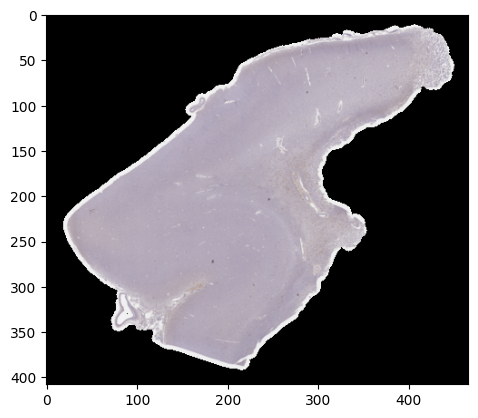

In [25]:
util.display_img(util.mask_rgb(np_img, dilation))

In [26]:
t.elapsed_display()

Time elapsed: 0:00:01.348249


# Entropy Masker

Source: [An automatic entropy method to efficiently mask histology whole-slide images](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10017682/)

RGB                  | Time: 0:00:00.000226  Type: uint8   Shape: (408, 466, 3)


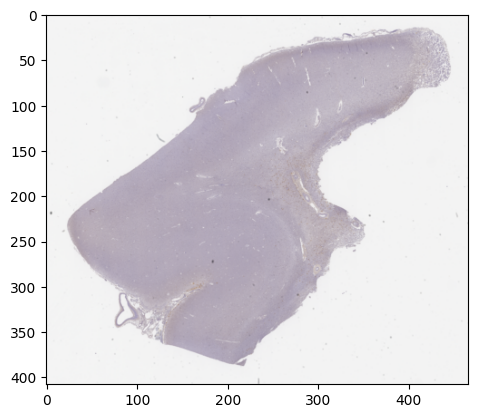

In [27]:
t = util.Time()
FILE = 'data/U.svs'
np_img = slide.slide_to_scaled_np_image(FILE, 64)
util.display_img(np_img)

Gray                 | Time: 0:00:00.005953  Type: uint8   Shape: (408, 466)


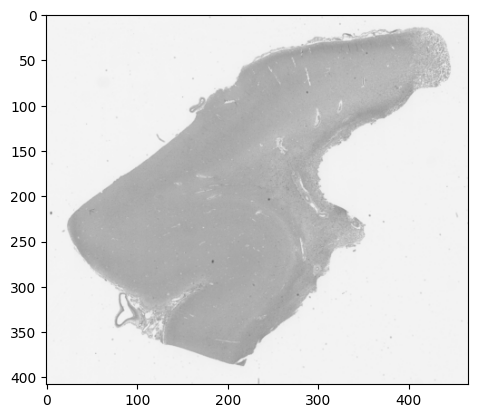

In [28]:
grayscale = filter.filter_rgb_to_grayscale(np_img)
util.display_img(grayscale)

Entropy              | Time: 0:00:00.088915  Type: uint8   Shape: (408, 466)


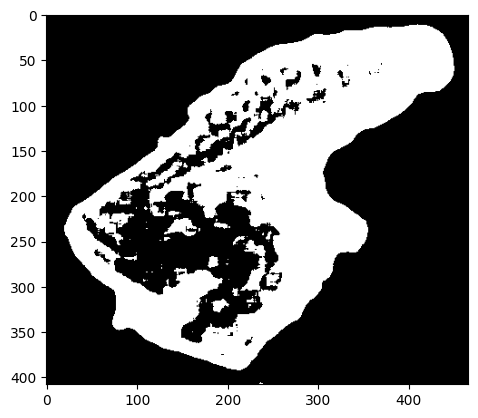

In [29]:
entropy = filter.filter_entropy(grayscale, neighborhood=12, threshold=3)
util.display_img(entropy)

Mask RGB             | Time: 0:00:00.001404  Type: uint8   Shape: (408, 466, 3)


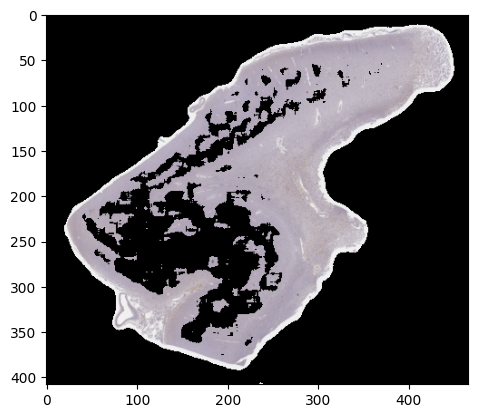

In [30]:
util.display_img(util.mask_rgb(np_img, entropy))

In [31]:
t.elapsed_display()

Time elapsed: 0:00:00.810541
